In [24]:
!pip install swig
!pip install gym
!apt-get install -y python-box2d
!pip install gym[box2d]


  Using cached swig-4.2.1-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.9 MB)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-box2d
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Using cached pygame-2.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376133 sha256=7e1aa79af647a971b7880ed4d5c6981c27bcf776d18a7b5e289ee24e5feb75d7
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


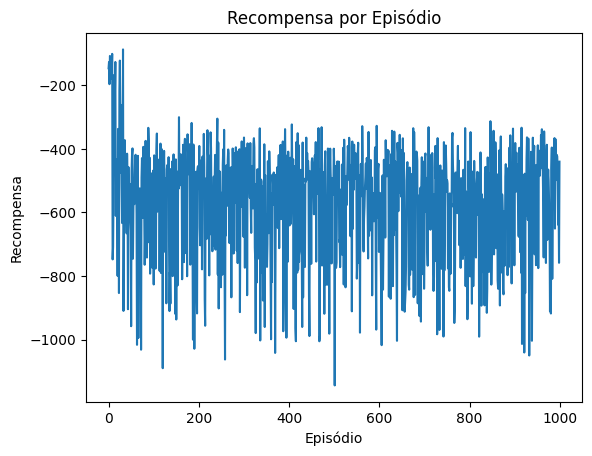

In [35]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define a classe da rede neural
class QNetwork(tf.keras.Model):
    def __init__(self, num_actions):
        super(QNetwork, self).__init__()
        self.dense1 = layers.Dense(128, activation='relu')
        self.dense2 = layers.Dense(64, activation='relu')
        self.q_values = layers.Dense(num_actions, activation='linear')

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        q_values = self.q_values(x)
        return q_values

# Função de Q-Learning aproximado
def q_learning(env, model, optimizer, gamma=0.99, epsilon=0.1, epsilon_decay=0.995, epsilon_min=0.01, num_episodes=1000):
    episode_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        done = False

        while not done:
            state_tensor = tf.convert_to_tensor(state[None, :], dtype=tf.float32)
            action_values = model(state_tensor)

            # Escolher a ação epsilon-greedy
            if np.random.rand() <= epsilon:
                action = env.action_space.sample()
            else:
                action = action_values[0].numpy()

            next_state, reward, done, _ = env.step(action)

            # Atualizar a Q-value
            next_state_tensor = tf.convert_to_tensor(next_state[None, :], dtype=tf.float32)
            target_q = reward + gamma * tf.reduce_max(model(next_state_tensor), axis=1)
            with tf.GradientTape() as tape:
                q_values = model(tf.convert_to_tensor(state[None, :], dtype=tf.float32))
                action_one_hot = tf.one_hot(action, env.action_space.shape[0])
                predicted_q = tf.reduce_sum(tf.multiply(q_values, action_one_hot), axis=1)
                loss = tf.reduce_mean(tf.square(target_q - predicted_q))

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            state = next_state
            episode_reward += reward

        episode_rewards.append(episode_reward)
        epsilon = max(epsilon_min, epsilon_decay * epsilon)

    return episode_rewards

# Criar ambiente LunarLanderContinuous
env = gym.make('LunarLanderContinuous-v2')

# Número de unidades na camada de saída da rede neural
num_actions = env.action_space.shape[0]

# Criar e compilar o modelo da rede neural
model = QNetwork(num_actions)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Executar Q-Learning
episode_rewards = q_learning(env, model, optimizer)

# Visualizar o treinamento

plt.plot(episode_rewards)
plt.xlabel('Episódio')
plt.ylabel('Recompensa')
plt.title('Recompensa por Episódio')
plt.show()
